In [1]:
import os
import torch

from dataset import load_dataset
from torch.nn import functional as F

from modules import VQVAE
PATH = os.getcwd() + '/'
DATA_PATH_TRAINING_RANGPUR = '/home/groups/comp3710/OASIS'
DATA_PATH_TRAINING_LOCAL = PATH + 'test_img/'
BATCH_SIZE = 32
EPOCHS = 2

# Taken from paper and YouTube video
N_HIDDEN_LAYERS = 128
N_RESIDUAL_HIDDENS = 32
N_RESIDUAL_LAYERS = 2

EMBEDDINGS_DIM = 64 # Dimension of each embedding in the codebook (embeddings vector)
N_EMBEDDINGS = 512 # Size of the codebook (number of embeddings)

BETA = 0.25
LEARNING_RATE = 1e-3


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
data_path_training = PATH + 'test_img/'

vqvae = VQVAE(n_hidden_layers=N_HIDDEN_LAYERS, n_residual_hidden_layers=N_RESIDUAL_HIDDENS, n_embeddings=N_EMBEDDINGS, embeddings_dim=EMBEDDINGS_DIM, beta=BETA).to(device)

# open the model we saved in train_vqvae.py
model = torch.nn.Module.load_state_dict(vqvae, state_dict=torch.load(PATH + 'vqvae.pth'))
train_dl, data_variance = load_dataset(data_path_training, BATCH_SIZE)


vqvae.eval()
test_loss = []
with torch.no_grad():
	for i, (data, _) in enumerate(train_dl):
		data = data.to(device)
		vq_loss, z_q = vqvae(data)
		recons_error = F.mse_loss(z_q, data) / data_variance
		test_loss.append(recons_error.item())

avg_test_loss = sum(test_loss) / len(test_loss)
print('====> Test set loss: {:.4f}'.format(avg_test_loss))

====> Test set loss: 1.0657


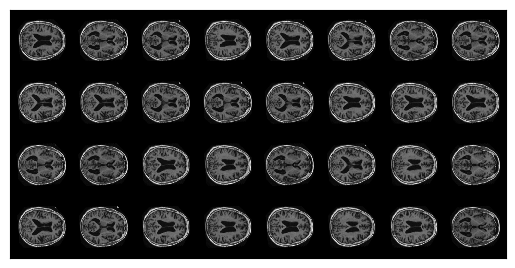

In [2]:
import matplotlib.pyplot as plt
from dataset import show_batch, show_images
from modules import Encoder, Decoder, VectorQuantizer
# show the original image

# img = next(iter(train_dl))
show_batch(train_dl)
plt.show()
img = next(iter(train_dl))
img = img[0]

# clear the plt.show()

# show the reconstructed image
test_recon = vqvae.conv1(vqvae.encoder(img))
_, test_recon = vqvae.vector_quantizer(test_recon)
final = vqvae.decoder(test_recon)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


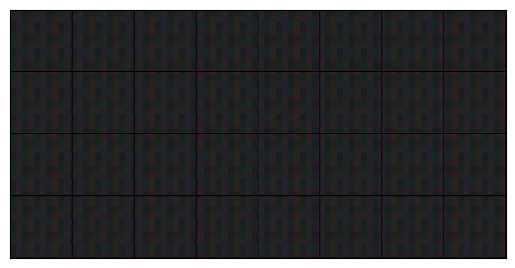

In [3]:
from torchvision.utils import make_grid
import numpy as np

test_real = next(iter(train_dl)) # load some from test dl
test_real = test_real[0]
test_real = test_real.to('cpu')
pre_conv = vqvae.conv1(vqvae.encoder(test_real)) # encoder, reshape
_, test_quantized = vqvae.vector_quantizer(pre_conv)
test_reconstructions = vqvae.decoder(test_quantized)

# def show(img):
#   """
#   Plotting func
#   """
#   npimg = img.numpy()
#   fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
#   fig.axes.get_xaxis().set_visible(False)
#   fig.axes.get_yaxis().set_visible(False)

# show reconstructed images
show_images(make_grid(test_reconstructions.cpu()))

In [ ]:
import numpy as np
from torchvision.utils import make_grid

def show(img):
  """
  Plotting func
  """
  npimg = img.numpy()
  fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
show(make_grid(final.cpu()))


Generate codebook indice from GAN. 

We use the GAN to generate an image, then use the latent space to generate a codebook indice.
* Convert using quantizer. 
* Then decode it using the vqvae decoder.

At first, train usual VQVAE (here, codebook is initialized uniformly and that is the problem). Then, to solve certain problems of uniform initialization of codebook, freeze VQVAE and train PixelCNN to predict your vector quantized vectors (represented as indices). Then, just replace codebook by PixelCNN predictions. That is it



